# Neural Machine Translation
#### Applied Text Mining - Utrecht Summer School

Welcome to the seventh practical of the course “Applied Text Mining”. 

In this practical, we will create models for neural machine translation. Today we are curious to see how a simple deep learning based model translates a sentence into its counterpart. See these examples:

<img src="translation_example.png">

<img src="translation_example2.png">

The objective from this practical is to convert a Dutch sentence to its English counterpart using a Neural Machine Translation (NMT) system. We will implement this task by building a simple Sequence-to-Sequence model with the help of Keras library.

Today we will use the following libraries. Take care to have them installed!

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
# matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Let's get started!

1\. **.**

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

2\. **.**

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

3\. **.**

In [46]:
data = read_text("nld-eng/nld.txt")
nld_eng = to_lines(data)
nld_eng = array(nld_eng)

In [47]:
nld_eng.shape

(54972, 3)

In [10]:
nld_eng = nld_eng[:5000,:]

In [11]:
nld_eng

array([['Go.', 'Lopen!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['Go.', 'Vooruit.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['Hi.', 'Hoi.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['Did you find it?', 'Heb je het gevonden?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3333986 (CK) & #9333148 (megamanenm)'],
       ['Did you find it?', 'Heb jij het gevonden?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3333986 (CK) & #9333150 (megamanenm)'],
       ['Did you get wet?', 'Bent u nat geworden?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5853263 (CK) & #8538509 (simonbr)']],
      dtype='<U286')

In [48]:
nld_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in nld_eng[:,0]]
nld_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in nld_eng[:,1]]

In [49]:
nld_eng

array([['Go', 'Lopen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['Go', 'Vooruit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['Hi', 'Hoi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['Always use distilled water in steam irons because using ordinary water will cause a mineral buildup over time that will clog the steam holes',
        'Gebruik altijd gedistilleerd water in stoomstrijkijzers want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ['If you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'Als je vanuit je tweede taal naar je eigen moedertaal vertaalt in pla

In [50]:
# convert to lowercase
for i in range(len(nld_eng)):
    nld_eng[i,0] = nld_eng[i,0].lower()    
    nld_eng[i,1] = nld_eng[i,1].lower()

In [51]:
nld_eng

array([['go', 'lopen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['go', 'vooruit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['hi', 'hoi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['always use distilled water in steam irons because using ordinary water will cause a mineral buildup over time that will clog the steam holes',
        'gebruik altijd gedistilleerd water in stoomstrijkijzers want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ['if you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'als je vanuit je tweede taal naar je eigen moedertaal vertaalt in pla

In [52]:
# empty lists
eng_l = []
nld_l = []

# populate the lists with sentence lengths
for i in nld_eng[:,0]:
    eng_l.append(len(i.split()))

for i in nld_eng[:,1]:
    nld_l.append(len(i.split()))

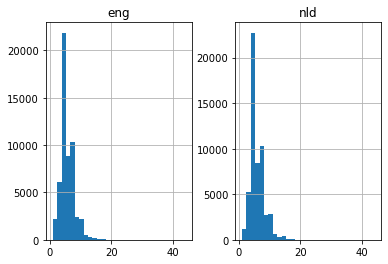

In [53]:
length_df = pd.DataFrame({'eng':eng_l, 'nld':nld_l})
length_df.hist(bins = 30)
plt.show()

In [54]:
max(eng_l)

44

In [55]:
max(nld_l)

44

In [62]:
type(nld_l)
import statistics
statistics.mean(nld_l)

5.853307138179437

In [63]:
statistics.mean(eng_l)

5.619569962890199

The maximum length of the Dutch sentences is 12 and that of the English phrases is 5.

In [56]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [64]:
# prepare english tokenizer
eng_tokenizer = tokenization(nld_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 6
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 9073


In [65]:
# prepare Dutch tokenizer
nld_tokenizer = tokenization(nld_eng[:, 1])
nld_vocab_size = len(nld_tokenizer.word_index) + 1

nld_length = 6
print('Deutch Vocabulary Size: %d' % nld_vocab_size)

Deutch Vocabulary Size: 12794


In [66]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [67]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(nld_eng, test_size=0.2, random_state = 12)

In [68]:
# prepare training data
trainX = encode_sequences(nld_tokenizer, nld_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [69]:
# prepare validation data
testX = encode_sequences(nld_tokenizer, nld_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [70]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [71]:
model = build_model(nld_vocab_size, eng_vocab_size, nld_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [72]:
filename = 'model.h1.09_jun_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 5.7361
Epoch 00001: val_loss improved from inf to 5.32297, saving model to model.h1.09_jul_21
INFO:tensorflow:Assets written to: model.h1.09_jul_21\assets
69/69 [==============================] - 101s 1s/step - loss: 5.7361 - val_loss: 5.3230
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 5.2138
Epoch 00002: val_loss improved from 5.32297 to 5.18957, saving model to model.h1.09_jul_21
INFO:tensorflow:Assets written to: model.h1.09_jul_21\assets
69/69 [==============================] - 111s 2s/step - loss: 5.2138 - val_loss: 5.1896
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 5.0032
Epoch 00003: val_loss improved from 5.18957 to 5.04063, saving model to model.h1.09_jul_21
INFO:tensorflow:Assets written to: model.h1.09_jul_21\assets
69/69 [==============================] - 112s 2s/step - loss: 5.0032 - val_loss: 5.0406
Epoch 4/10
69/69 [==============================] - ETA: 0s

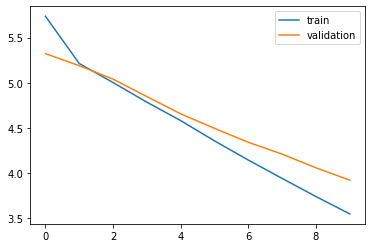

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [74]:
model = load_model('model.h1.09_jun_21')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [75]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [76]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [77]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})


In [78]:
pd.set_option('display.max_colwidth', 50)


In [79]:
pred_df.head(15)


,actual,predicted
0,i must refuse,i have to a
1,they are singers,theyre they
2,who switched off the light,they the
3,tom was really different,tom is have
4,do you need anything,do you need
5,im fixing the clock,i opened the
6,i cant tell you when tom will get here,tom to us
7,he solved the problem with ease,the are in
8,im not suicidal,i dont have a
9,please take another one,please a


In [80]:
pred_df


,actual,predicted
0,i must refuse,i have to a
1,they are singers,theyre they
2,who switched off the light,they the
3,tom was really different,tom is have
4,do you need anything,do you need
...,...,...
10990,i told you it was too soon,you to the it
10991,whose book is this,this is this
10992,get out,get
10993,how did your interview go,how did you this


In [81]:
pred_df.sample(15)


,actual,predicted
1542,luckily the weather turned out fine,dont to
2595,have you lost weight,do you like
1315,unfortunately she lives abroad,he was in
9048,there was a pretty girl with black hair in the...,in a in the days
6782,thats the way it goes,is
8634,i think i was the one who suggested that,the was
2541,he cured my illness,he was my
2409,dont forget to tip the waiter,the to
6093,is that a cow or a buffalo,my a my car
6187,tom probably doesnt know where mary is going t...,i when to him
